In [84]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import scipy.sparse as sp
import numpy as np
import torch.optim as optim
import pandas as pd
from torch_geometric.data import Data
from torch.utils.data import Dataset, DataLoader
import torch_geometric.transforms as T


seed = 12345

np.random.seed(seed)  # seed for numpy
torch.manual_seed(seed)  # seed for PyTorch CPU

In [2]:
def normalization(adjacency):
    """ 
    degree matrix
    L=D^-0.5 * (A+I) * D^-0.5
    """
    # adjacency += sp.eye(adjacency.shape[0])    # 
    adjacency =sp.coo_matrix(adjacency)
    degree = np.array(adjacency.sum(1)) # 
    d_hat = sp.diags(np.power(degree, -0.5).flatten())
    adj_normalized = d_hat.dot(adjacency).dot(d_hat).tocoo()
    adj_normalized = sp.csc_matrix.todense(adj_normalized) #
    return adj_normalized


DEVICE='cpu'

hidden_m =256   
decod = 128
LEARNING_RATE = 0.01
WEIGHT_DACAY = 5e-4   

BASE = '/Users/chensiang/Desktop/深度学习/GraLTR-LDA_main/independent_test'
dataset_name = 'iLncDA-LTR'

# training set
adj = np.load(BASE+'/datasets/'+dataset_name+'/1044_LD.npy')

# lncRNA-lncRNA adjacency matrix have been with self-loop
lnc_x = np.load(BASE+'/datasets/'+dataset_name+'/'+dataset_name+'_lnc.npy')
lnc_x = np.float32(lnc_x)

# disease-disease adjacency matrix have been with self-loop 
dis_x = np.load(BASE+'/datasets/'+dataset_name+'/'+dataset_name+'_dis.npy')
dis_x = np.float32(dis_x)

# Construct the adjacency matrix A_LD
A_LD = np.vstack((np.hstack((lnc_x,adj)),np.hstack((adj.T,dis_x))))
A_LD = np.float32(A_LD) # 
# init the graph node feature
X_LD = A_LD.copy() # 

LD_adj = normalization(A_LD.copy()) # 


A_L = lnc_x.copy() #
A_L = normalization(A_L.copy())# 
X_L = X_LD[:lnc_x.shape[0]].copy() # 

A_D = dis_x.copy() #
A_D = normalization(A_D.copy())# 
X_D = X_LD[lnc_x.shape[0]:].copy() # 

input_num = adj.shape[0] + adj.shape[1]


A_L = torch.from_numpy(A_L)
X_L = torch.from_numpy(X_L)
A_D = torch.from_numpy(A_D)
X_D = torch.from_numpy(X_D)
LD_adj = torch.from_numpy(LD_adj)
X_LD = torch.from_numpy(X_LD)

In [ ]:
X_LD.shape, LD_adj.shape

In [3]:
from torch_geometric.nn import GCNConv
from torch_geometric.nn import GAE

class GCNEncoder(nn.Module):
    def  __init__(self, in_channels, hidden_size, out_channels, dropout):
        super(GCNEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_size, cached=True)
        self.conv2 = GCNConv(hidden_size, out_channels, cached=True)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.dropout(x)
        return self.conv2(x, edge_index)


In [4]:
df = pd.read_csv("/Users/chensiang/Downloads/DG-AssocMiner_miner-disease-gene.tsv",sep="\t")


In [5]:
dis_idx = {}
k = 0
for dis in df.Disease_ID:
    if dis not in dis_idx.keys():
        dis_idx[dis] = k
        k += 1

gene_idx = {}
for gene in df.Gene_ID:
    if gene not in gene_idx.keys():
        gene_idx[gene] = k
        k += 1
#0-518号疾病，519-7812号基因
adj_size = len(dis_idx) + len(gene_idx)
adj_matrix = torch.zeros((adj_size, adj_size))
for dis, gene in zip(df.Disease_ID, df.Gene_ID):
    adj_matrix[dis_idx[dis]][gene_idx[gene]] = 1
    
edge_idx = torch.cat([_.unsqueeze(0) for _ in torch.where(adj_matrix==1)])
reverse_edge_idx = torch.cat([edge_idx[1].unsqueeze(0), edge_idx[0].unsqueeze(0)],dim=0)
edge_idx, reverse_edge_idx

(tensor([[   0,    0,    0,  ...,  518,  518,  518],
         [ 519,  520,  521,  ..., 7810, 7811, 7812]]),
 tensor([[ 519,  520,  521,  ..., 7810, 7811, 7812],
         [   0,    0,    0,  ...,  518,  518,  518]]))

In [6]:
num_features = 1
hidden_dim = 128
out_dim = 16
num_epochs = 400

In [7]:
data = Data()
data.num_nodes = adj_size
data.edge_index = torch.cat((edge_idx, reverse_edge_idx), dim=1)
data.x = torch.ones(data.num_nodes, num_features)

In [8]:
tfm = T.Compose([T.RandomLinkSplit(num_val=0.05, num_test=0.15, is_undirected=True,split_labels=True,add_negative_train_samples=True)])
train_dataset, val_dataset, test_dataset = tfm(data)

In [9]:
train_dataset

Data(num_nodes=7813, edge_index=[2, 34174], x=[7813, 1], pos_edge_label=[17087], pos_edge_label_index=[2, 17087], neg_edge_label=[17087], neg_edge_label_index=[2, 17087])

In [10]:
def gae_train(train_data, gae_model, optimizer):
    gae_model.train()
    optimizer.zero_grad()
    z = gae_model.encode(train_data.x, train_data.edge_index)
    loss = gae_model.recon_loss(z, train_data.pos_edge_label_index)
    loss.backward(retain_graph=True)
    optimizer.step()
    return float(loss)

@torch.no_grad()
def gae_test(test_data, gae_model):
    gae_model.eval()
    z = gae_model.encode(test_data.x, test_data.edge_index)
    return gae_model.test(z, test_data.pos_edge_label_index, test_data.neg_edge_label_index)


losses = []
test_auc = []
test_ap = []
train_aucs = []
train_aps = []

gae_model = GAE(GCNEncoder(num_features, hidden_dim, out_dim, 0.5))
optimizer = torch.optim.Adam(gae_model.parameters(), lr=0.01)

for epoch in range(1, num_epochs + 1):
    loss = gae_train(train_dataset, gae_model, optimizer)
    losses.append(loss)
    auc, ap = gae_test(test_dataset, gae_model)
    test_auc.append(auc)
    test_ap.append(ap)

    train_auc, train_ap = gae_test(train_dataset, gae_model)

    train_aucs.append(train_auc)
    train_aps.append(train_ap)

    if(epoch % 100 == 0):
        print('Epoch: {:03d}, test AUC: {:.4f}, test AP: {:.4f}, train AUC: {:.4f}, train AP: {:.4f}, loss:{:.4f}'.format(epoch, auc, ap, train_auc, train_ap, loss))


Epoch: 100, test AUC: 0.9610, test AP: 0.9569, train AUC: 0.9610, train AP: 0.9547, loss:1.0647
Epoch: 200, test AUC: 0.9598, test AP: 0.9561, train AUC: 0.9594, train AP: 0.9549, loss:1.0369
Epoch: 300, test AUC: 0.9567, test AP: 0.9536, train AUC: 0.9570, train AP: 0.9541, loss:1.0425
Epoch: 400, test AUC: 0.9464, test AP: 0.9477, train AUC: 0.9565, train AP: 0.9540, loss:1.0402


In [4]:
import matplotlib.pyplot as plt
%matplotlib inline


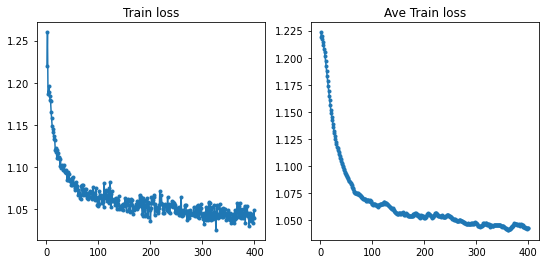

In [27]:
x = range(1, num_epochs+1)
ave_loss = losses.copy()
for k in range(1, len(ave_loss)):
    ave_loss[k] = 0.9 * ave_loss[k-1] + 0.1 * ave_loss[k]

plt.figure(figsize=(9, 4))
plt.subplot(121)
plt.plot(x , losses, '.-')
plt.title('Train loss')
plt.subplot(122)
plt.plot(x , ave_loss, '.-')
plt.title('Ave Train loss')
plt.show()

In [48]:
import random


k_folds = 10
index_matrix = np.mat(np.where(np.triu(A_LD) == 1))
association_nam = index_matrix.shape[1]
random_index = index_matrix.T.tolist()
random.seed(seed)
random.shuffle(random_index)
CV_size = int(association_nam / k_folds)
temp = np.array(random_index[:association_nam - association_nam %
                                 k_folds]).reshape(k_folds, CV_size,  -1).tolist()
temp[k_folds - 1] = temp[k_folds - 1] + \
        random_index[association_nam - association_nam % k_folds:]

random_index = temp

edge_index = torch.from_numpy(index_matrix)
val_edge_index = torch.tensor(np.array(random_index[5])).transpose(0, 1)
train_edge_index = torch.cat((torch.tensor(np.concatenate(random_index[:5])), torch.tensor(np.concatenate(random_index[6:])))).transpose(0, 1)

edge_index.shape, val_edge_index.shape, train_edge_index.shape

(torch.Size([2, 9886]), torch.Size([2, 988]), torch.Size([2, 8898]))

In [49]:
rev_train_edge_index = torch.cat((train_edge_index[1].unsqueeze(0), train_edge_index[0].unsqueeze(0)), dim=0)
rev_val_edge_index = torch.cat((val_edge_index[1].unsqueeze(0), val_edge_index[0].unsqueeze(0)), dim=0)
train_edge_index = torch.cat((train_edge_index ,rev_train_edge_index), dim=1)
val_edge_index = torch.cat((val_edge_index ,rev_val_edge_index), dim=1)
val_edge_index.shape, train_edge_index.shape

(torch.Size([2, 1976]), torch.Size([2, 17796]))

In [83]:
train_edge_index[:,:17796//2].shape, train_edge_index[:,:17796//2].shape

torch.Size([2, 8898])

In [93]:
for batch in edges_loader:
    print(batch.transpose(0, 1).shape)
    break

torch.Size([2, 64])


In [51]:
from torch_geometric.nn import GCNConv
from torch_geometric.nn import InnerProductDecoder
from torch_geometric.nn import GAE
EPS = 1e-15

class GCNEncoder(nn.Module):
    def  __init__(self, in_channels, hidden_size, out_channels, dropout):
        super(GCNEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_size, cached=True)
        self.conv2 = GCNConv(hidden_size, out_channels, cached=True)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.dropout(x)
        return self.conv2(x, edge_index)

'''    
class GraphAutoEncoder(nn.Module):
    def __init__(self, encoder, decoder=InnerProductDecoder(), graph_type='sparse'):
        super(GraphAutoEncoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.graph_type = graph_type
    
    def encode(self, x, edge_index):
        return self.encoder(x, edge_index)
    
    def recon_loss(self, z, pos_edge_index, neg_edge_index=None):
        pos_loss = -torch.log(
            self.decoder(z, pos_edge_index, sigmoid=True) + EPS).mean()
        if neg_edge_index is None:
            neg_edge_index = negative_sampling(pos_edge_index, z.size(0),method=self.graph_type)
        neg_loss = -torch.log(1 -
                              self.decoder(z, neg_edge_index, sigmoid=True) +
                              EPS).mean()

        return pos_loss + neg_loss
    
    def test(self, z, pos_edge_index, neg_edge_index):
        from sklearn.metrics import average_precision_score, roc_auc_score

        pos_y = z.new_ones(pos_edge_index.size(1))
        neg_y = z.new_zeros(neg_edge_index.size(1))
        y = torch.cat([pos_y, neg_y], dim=0)

        pos_pred = self.decoder(z, pos_edge_index, sigmoid=True)
        neg_pred = self.decoder(z, neg_edge_index, sigmoid=True)
        pred = torch.cat([pos_pred, neg_pred], dim=0)

        y, pred = y.detach().cpu().numpy(), pred.detach().cpu().numpy()

        return roc_auc_score(y, pred), average_precision_score(y, pred)
    '''
class GraphAutoEncoder(nn.Module):
    def __init__(self, gae, graph_type='sparse'):
        super(GraphAutoEncoder, self).__init__()
        self.gae = gae
        self.graph_type = graph_type
    
    def encode(self, x, edge_index):
        return self.gae.encode(x, edge_index)
    
    def test(self, z, pos_edge_index, neg_edge_index):
        return self.gae.test(z, pos_edge_index, neg_edge_index)
    
    def recon_loss(self, z, pos_edge_index, neg_edge_index=None):
        pos_loss = -torch.log(
            self.gae.decoder(z, pos_edge_index, sigmoid=True) + EPS).mean()
        if neg_edge_index is None:
            neg_edge_index = negative_sampling(pos_edge_index, z.size(0),method=self.graph_type)
        neg_loss = -torch.log(1 -
                              self.gae.decoder(z, neg_edge_index, sigmoid=True) +
                              EPS).mean()

        return pos_loss + neg_loss

In [ ]:
class myedge_idx(Dataset):
    def __init__(self, edge):
        super(myedge_idx, self).__init__()
        self.edge = edge
    
    def __getitem__(self, idx):
        return self.edge[:,idx]
    
    def __len__(self):
        return self.edge.shape[1]
edges = myedge_idx(train_edge_index[:,:17796//2])
edges_loader = DataLoader(edges, shuffle=True, batch_size=64)

In [ ]:
from torch_geometric.utils import negative_sampling


EPOCHS = 200
learning_rate = 0.01

#NUM_FEATURES = X_LD.shape[1]
NUM_FEATURES = 1
HIDDEN_SIZE = 128
OUT_CHANNELS = 32

X = torch.ones(X_LD.shape[0],1)
gae_model = GAE(GCNEncoder(NUM_FEATURES, HIDDEN_SIZE, OUT_CHANNELS, 0.5))
#gae_model = GraphAutoEncoder(GCNEncoder(NUM_FEATURES, HIDDEN_SIZE, OUT_CHANNELS, 0.5), graph_type='dense')
#gae_model = GraphAutoEncoder(gae=GAE(GCNEncoder(NUM_FEATURES, HIDDEN_SIZE, OUT_CHANNELS, 0.5)), graph_type='dense')

def gae_train(x, edge_index, train_idx, gae_model, optimizer):
#def gae_train(x, edge_index, gae_model, optimizer):
    gae_model.train()
    optimizer.zero_grad()
    z = gae_model.encode(x, edge_index)
    #loss = gae_model.recon_loss(z, edge_index)
    loss = gae_model.recon_loss(z, train_idx)
    loss.backward(retain_graph=True)
    optimizer.step()
    return z, float(loss)


@torch.no_grad()
def gae_test(z, pos_edge_index, gae_model):
    gae_model.eval()
    # neg_edge_index = negative_sampling(pos_edge_index, z.size(0), method='dense')
    # neg_edge_index = negative_sampling(pos_edge_index, z.size(0))
    
    return gae_model.recon_loss(z, pos_edge_index)

losses = []
test_auc = []
test_ap = []
train_aucs = []
train_aps = []
val_losses = []
optimizer = torch.optim.Adam(gae_model.parameters(), lr=learning_rate)

for epoch in range(1, EPOCHS + 1):
    
    '''
    z, loss = gae_train(X, train_edge_index, gae_model, optimizer)
    losses.append(loss)
    
    auc, ap = gae_test(z, val_edge_index, gae_model)
    test_auc.append(auc)
    test_ap.append(ap)

    train_auc, train_ap = gae_test(z, train_edge_index, gae_model)

    train_aucs.append(train_auc)
    train_aps.append(train_ap)
    '''
    for batch in edges_loader:
        i_to_j_egdes = batch.transpose(0, 1)
        j_to_i_edges = torch.cat((i_to_j_egdes[1].unsqueeze(0), i_to_j_egdes[0].unsqueeze(0)), dim=0)
        two_edges = torch.cat((i_to_j_egdes, j_to_i_edges),dim=1)
        z, loss = gae_train(X, train_edge_index, two_edges, gae_model, optimizer)
        #z, loss = gae_train(X, train_edge_index, gae_model, optimizer)
        losses.append(loss)
        val_loss = gae_test(z, val_edge_index, gae_model)
        val_losses.append(val_loss)
    
    
    if(epoch % 40 == 0):
        #print('Epoch: {:03d}, test AUC: {:.4f}, test AP: {:.4f}, train AUC: {:.4f}, train AP: {:.4f}, loss:{:.4f}'.format(epoch, auc, ap, train_auc, train_ap, loss))
        print('Epoch: {:03d}, loss:{:.4f}'.format(epoch, loss))

第一次训练结果：  
Epoch: 200, test AUC: 0.6420, test AP: 0.6422, train AUC: 0.6819, train AP: 0.6833, loss:1.3118  
Epoch: 400, test AUC: 0.6307, test AP: 0.6268, train AUC: 0.6712, train AP: 0.6722, loss:1.3283  
Epoch: 600, test AUC: 0.6398, test AP: 0.6426, train AUC: 0.6910, train AP: 0.6915, loss:1.3261  
Epoch: 800, test AUC: 0.6829, test AP: 0.6774, train AUC: 0.7279, train AP: 0.7293, loss:1.2676  
Epoch: 1000, test AUC: 0.6943, test AP: 0.6972, train AUC: 0.7430, train AP: 0.7420, loss:1.2542  
loss较高、test AUC和train AUC都不高的原因：边稠密，导致稀疏负采样不合理？

第二次训练结果，稠密图采样，不是该原因：  
Epoch: 200, test AUC: 0.6595, test AP: 0.6609, train AUC: 0.6777, train AP: 0.6777, loss:1.3163  
Epoch: 400, test AUC: 0.6514, test AP: 0.6529, train AUC: 0.7072, train AP: 0.7119, loss:1.2866  
Epoch: 600, test AUC: 0.6780, test AP: 0.6808, train AUC: 0.7134, train AP: 0.7212, loss:1.2780  
Epoch: 800, test AUC: 0.6520, test AP: 0.6550, train AUC: 0.7097, train AP: 0.7101, loss:1.2859  
Epoch: 1000, test AUC: 0.6812, test AP: 0.6830, train AUC: 0.7278, train AP: 0.7301, loss:1.2647

第三次训练结果，考虑学习率的问题导致学习停滞，修改0.01->0.00  
Epoch: 200, test AUC: 0.6535, test AP: 0.6590, train AUC: 0.6937, train AP: 0.6938, loss:1.3442  
Epoch: 400, test AUC: 0.6392, test AP: 0.6461, train AUC: 0.6672, train AP: 0.6730, loss:1.3159  
Epoch: 600, test AUC: 0.6450, test AP: 0.6409, train AUC: 0.6818, train AP: 0.6886, loss:1.2972  
Epoch: 800, test AUC: 0.6576, test AP: 0.6670, train AUC: 0.6956, train AP: 0.7015, loss:1.2816  
Epoch: 1000, test AUC: 0.6891, test AP: 0.6811, train AUC: 0.7255, train AP: 0.7225, loss:1.2595  
可以看到调小学习率后，400个epochs才接近最优，所以说明前面几次学到了最优，数据集中包含的信息已经被模型充分学习。loss也更平滑一点

调小模型：  
第四次训练，HIDDEN_SIZE = 64，OUT_CHANNELS = 32  
第五次训练，HIDDEN_SIZE = 64，OUT_CHANNELS = 16  
收敛得更快了（因为参数数量更少了），但最终loss都在1.27,1.28左右，学习效果没那么好，

调大模型：  
第六次训练，HIDDEN_SIZE = 128，OUT_CHANNELS = 16  
最终损失较之前大，loss曲线震荡，参数空间太大，考虑调小学习率  
第七次训练，HIDDEN_SIZE = 128，OUT_CHANNELS = 16，lr=0.001

**————边设置错误！！————**

第一次lr=0.01，HIDDEN_SIZE = 128，OUT_CHANNELS = 32  **效果最好**  
Epoch: 400, loss:1.2070  
Epoch: 800, loss:1.1964  
Epoch: 1200, loss:1.1854  
Epoch: 1600, loss:1.2279  
Epoch: 2000, loss:1.1780

第二次lr=0.001  
Epoch: 400, loss:1.3331  
Epoch: 800, loss:1.2560  
Epoch: 1200, loss:1.2158  
Epoch: 1600, loss:1.2194  
Epoch: 2000, loss:1.1954

第三次，稠密图采样，没有改善  
Epoch: 400, loss:1.3183  
Epoch: 800, loss:1.2321  
Epoch: 1200, loss:1.2133  
Epoch: 1600, loss:1.2102  
Epoch: 2000, loss:1.2019

第四次，调小模型lr=0.01，HIDDEN_SIZE = 64，OUT_CHANNELS = 16：  
Epoch: 400, loss:1.2549  
Epoch: 800, loss:1.1823  
Epoch: 1200, loss:1.2154  
Epoch: 1600, loss:1.1902  
Epoch: 2000, loss:1.2076

第一次1850epochs左右有训练和验证上都较优，而训练后期也还有明显震荡，调小学习率后震荡弱一些了但还是有，每次都是使用整个图所有边更新参数，梯度的改变可能会缺乏随机性，导致陷入局部最优，考虑是batch的

第五次训练，每个batch取64条边训练和计算损失，效果一般，考虑整个图训练？batch损失？  
Epoch: 040, loss:1.4594  
Epoch: 080, loss:1.3730  
Epoch: 120, loss:1.3565  
Epoch: 160, loss:1.3604  
Epoch: 200, loss:1.3617  
错误！损失越来越大,图信息传播过于稀疏

第六次，考虑整个图训练？batch损失，可能在batch上损失很小，但也只是这一小部分数据拟合得很好。看测试集最终loss和之前差不多，1.25左右 
Epoch: 040, loss:0.7127  
Epoch: 080, loss:1.3036  
Epoch: 120, loss:1.7431  
Epoch: 160, loss:1.4236  
Epoch: 200, loss:1.0128
换超参：****补实验，找一下论文可以怎么调参数

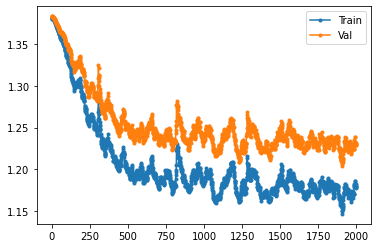

In [73]:
#第一次训练，
x = range(1, EPOCHS+1)
ave_losses = losses.copy()
for k in range(1, len(ave_losses)):
    ave_losses[k] = 0.9 * ave_losses[k-1] + 0.1 * ave_losses[k]
    
val_ave_losses = val_losses.copy()
for k in range(1, len(val_ave_losses)):
    val_ave_losses[k] = 0.9 * val_ave_losses[k-1] + 0.1 * val_ave_losses[k]   
plt.plot(ave_losses, '.-',label="Train")
plt.plot(val_ave_losses, '.-', label="Val")
plt.legend()
plt.show()

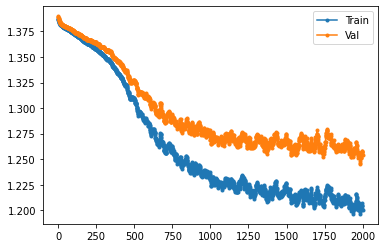

In [75]:
#第二次训练，
x = range(1, EPOCHS+1)
ave_losses = losses.copy()
for k in range(1, len(ave_losses)):
    ave_losses[k] = 0.9 * ave_losses[k-1] + 0.1 * ave_losses[k]
    
val_ave_losses = val_losses.copy()
for k in range(1, len(val_ave_losses)):
    val_ave_losses[k] = 0.9 * val_ave_losses[k-1] + 0.1 * val_ave_losses[k]   
plt.plot(ave_losses, '.-',label="Train")
plt.plot(val_ave_losses, '.-', label="Val")
plt.legend()
plt.show()

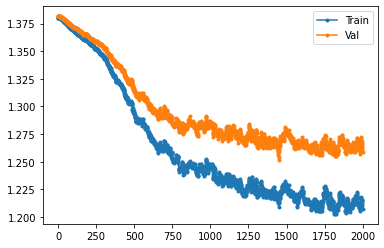

In [77]:
#第三次训练，
x = range(1, EPOCHS+1)
ave_losses = losses.copy()
for k in range(1, len(ave_losses)):
    ave_losses[k] = 0.9 * ave_losses[k-1] + 0.1 * ave_losses[k]
    
val_ave_losses = val_losses.copy()
for k in range(1, len(val_ave_losses)):
    val_ave_losses[k] = 0.9 * val_ave_losses[k-1] + 0.1 * val_ave_losses[k]   
plt.plot(ave_losses, '.-',label="Train")
plt.plot(val_ave_losses, '.-', label="Val")
plt.legend()
plt.show()

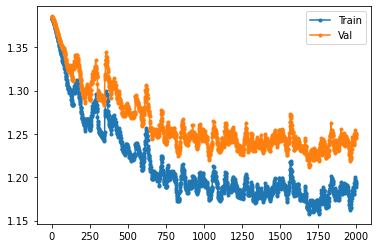

In [80]:
#第四次训练，
x = range(1, EPOCHS+1)
ave_losses = losses.copy()
for k in range(1, len(ave_losses)):
    ave_losses[k] = 0.9 * ave_losses[k-1] + 0.1 * ave_losses[k]
    
val_ave_losses = val_losses.copy()
for k in range(1, len(val_ave_losses)):
    val_ave_losses[k] = 0.9 * val_ave_losses[k-1] + 0.1 * val_ave_losses[k]   
plt.plot(ave_losses, '.-',label="Train")
plt.plot(val_ave_losses, '.-', label="Val")
plt.legend()
plt.show()

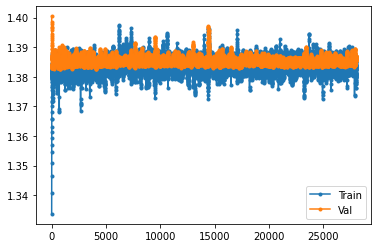

In [103]:
#第五次训练，
ave_losses = losses.copy()
for k in range(1, len(ave_losses)):
    ave_losses[k] = 0.9 * ave_losses[k-1] + 0.1 * ave_losses[k]
    
val_ave_losses = val_losses.copy()
for k in range(1, len(val_ave_losses)):
    val_ave_losses[k] = 0.9 * val_ave_losses[k-1] + 0.1 * val_ave_losses[k]   
plt.plot(ave_losses, '.-',label="Train")
plt.plot(val_ave_losses, '.-', label="Val")
plt.legend()
plt.show()

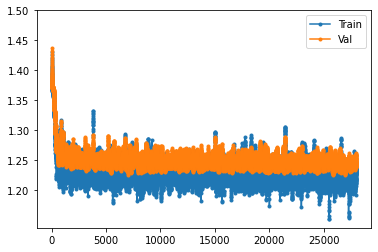

In [119]:
#第六次训练，
ave_losses = losses.copy()
for k in range(1, len(ave_losses)):
    ave_losses[k] = 0.9 * ave_losses[k-1] + 0.1 * ave_losses[k]
    
val_ave_losses = val_losses.copy()
for k in range(1, len(val_ave_losses)):
    val_ave_losses[k] = 0.9 * val_ave_losses[k-1] + 0.1 * val_ave_losses[k]   
plt.plot(ave_losses, '.-',label="Train")
plt.plot(val_ave_losses, '.-', label="Val")
plt.yticks(np.arange(1.2,1.5,0.05))
plt.legend()
plt.show()

In [120]:
sum(val_losses[5000:]) / len(val_losses[5000:])

tensor(1.2466)

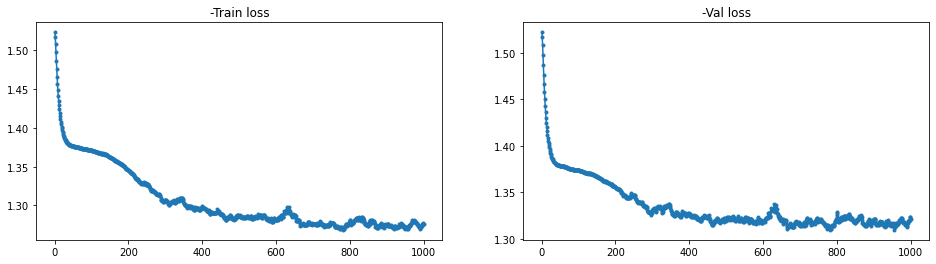

In [42]:
#第七次训练，
x = range(1, EPOCHS+1)
ave_losses = losses.copy()
for k in range(1, len(ave_losses)):
    ave_losses[k] = 0.9 * ave_losses[k-1] + 0.1 * ave_losses[k]
    
val_ave_losses = val_losses.copy()
for k in range(1, len(val_ave_losses)):
    val_ave_losses[k] = 0.9 * val_ave_losses[k-1] + 0.1 * val_ave_losses[k]   

plt.figure(figsize=(16, 4))
plt.subplot(121)
plt.plot(x , ave_losses, '.-')
plt.title('-Train loss')
plt.subplot(122)
plt.plot(x , val_ave_losses, '.-')
plt.title('-Val loss')
plt.show()

In [169]:
gae_model.eval()
with torch.no_grad():
    malat1 = (z @ z.t())[233].numpy()[404:]
    ranked_dis = np.argsort(-malat1)[:10]
dis_name = pd.read_csv("/Users/chensiang/Desktop/深度学习/GraLTR-LDA_main/case_study/datasets/iLncDA-LTR/disease_name.txt")

In [170]:
#第一次训练结果
dis_name.disease[ranked_dis]

30                       breast cancer
28        bladder urothelial carcinoma
33              cardiovascular disease
62                   esophageal cancer
74      gastrointestinal stromal tumor
73             gastrointestinal cancer
105                       liver cancer
139    pancreatic neuroendocrine tumor
69                  gallbladder cancer
158                    renal carcinoma
Name: disease, dtype: object

In [152]:
#第六次训练结果
dis_name.disease[ranked_dis]

32                      cancer
73     gastrointestinal cancer
30               breast cancer
62           esophageal cancer
116                   melanoma
75             germ cell tumor
80        head and neck cancer
79                glioblastoma
33      cardiovascular disease
136             ovarian cancer
Name: disease, dtype: object

bladder urothelial carcinoma，cardiovascular disease，gastrointestinal stromal tumor，gastrointestinal cancer，pancreatic neuroendocrine tumor，renal carcinoma
用第六次训练结果，对于lncRNA MALAT1，计算内积排前十的疾病，以下四个是不在训练表格中的，除了germ cell tumor，其他三个都有文献证实
gastrointestinal cancer，germ cell tumor，cardiovascular disease，head and neck cancer